In [1]:
%matplotlib inline
from glob import glob
import pandas as pd
import tables
import matplotlib.pyplot as plt
import numpy as np

In [2]:
window_scan = glob('windowLoss_*.h5')
windowLoss = []
neutronsInCell = []
neutronsOnWindow = []
totalNeutrons = []

for filename in window_scan:
    infile = tables.open_file(filename)
    params = infile.root.branch.neutron1D.attrs.params # get run attributes
    df = pd.DataFrame.from_records( infile.root.branch.neutron1D.read() ) # use either read() or read_where()
    infile.close()
    
    df['status'] = df['status'].str.decode("utf-8") # Status column in byte string format
    neutronsInCell.append( len(df.query('status=="cell"').index) )
    neutronsOnWindow.append( len( df.query('status=="window"').index ) )
    windowLoss.append(params['windowLoss'])
    totalNeutrons.append( len(df.index) )

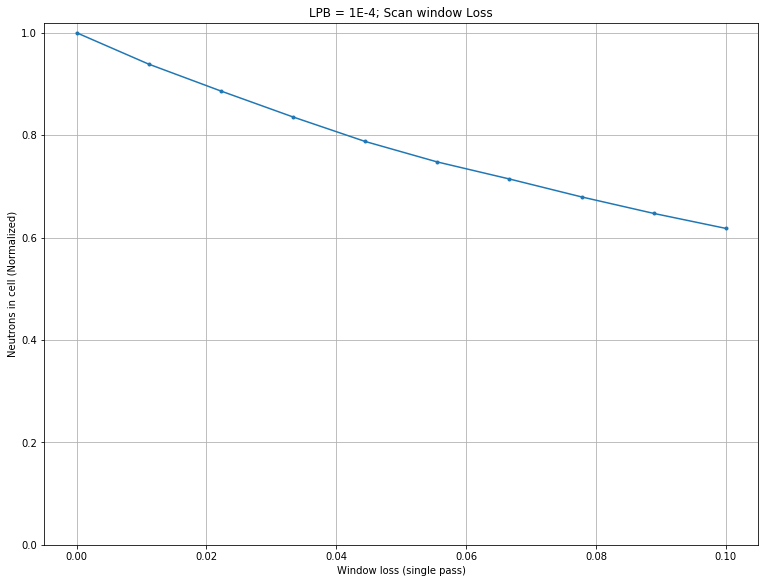

In [3]:
# plt.figure(figsize=[6.4*2,4.8*2])
# plt.figure()
# plt.plot(windowLoss, np.divide(neutronsInCell,totalNeutrons), marker='.')
# plt.ylim(0)
# plt.ylabel('% neutrons in cell')
# plt.xlabel('Window loss (single pass)')
# plt.grid()

plt.figure(figsize=(6.4*2, 4.8*2))
plt.title('LPB = 1E-4; Scan window Loss')
plt.plot(windowLoss, np.divide( neutronsInCell,np.amax(neutronsInCell) ), marker='.')
plt.ylim(0)
plt.ylabel('Neutrons in cell (Normalized)')
plt.xlabel('Window loss (single pass)')
plt.grid()



In [4]:
lpb_scan = glob('lpb_*.h5')
lossPerBounce = []
neutronsInCell = []
totalNeutrons = []
windowLoss = []

for filename in lpb_scan:
    infile = tables.open_file(filename)
    params = infile.root.branch.neutron1D.attrs.params # get run attributes
    df = pd.DataFrame.from_records( infile.root.branch.neutron1D.read() ) # use either read() or read_where()
    infile.close()
    
    df['status'] = df['status'].str.decode("utf-8") # Status column in byte string format
    neutronsInCell.append( len(df.query('status=="cell"').index) )
    totalNeutrons.append( len(df.index) )
    lossPerBounce.append( params['lossPerBounce'])
    windowLoss.append( params['windowLoss'])

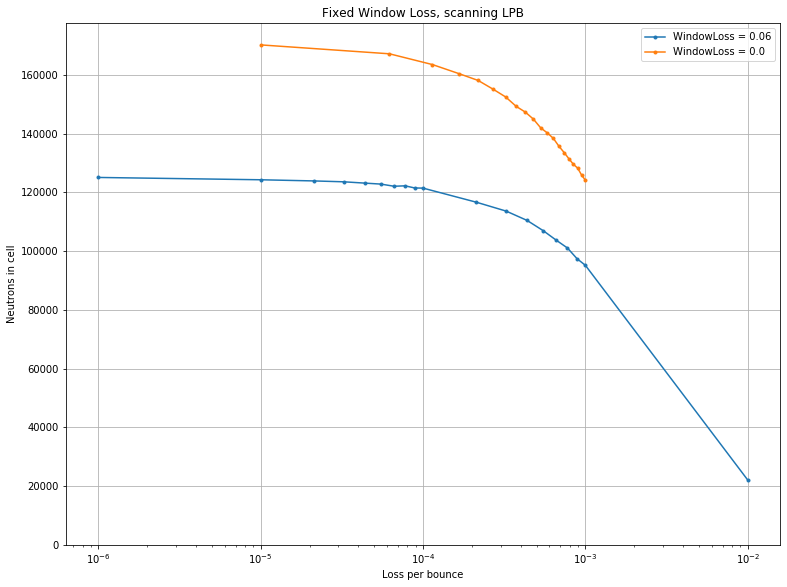

In [41]:
df = pd.DataFrame({'windowLoss':windowLoss, 
                   'lossPerBounce':lossPerBounce, 
                   'neutronsInCell':neutronsInCell, 
                   'totalNeutrons':totalNeutrons})
plt.figure(figsize=(6.4*2, 4.8*2))


for wl in df['windowLoss'].unique():
    dfQ = df.query('windowLoss == @wl').sort_values(by='lossPerBounce')
    plt.plot(dfQ['lossPerBounce'], dfQ['neutronsInCell'], marker='.', label=f'WindowLoss = {wl}')
    
plt.title('Fixed Window Loss, scanning LPB')
plt.ylim(0)
plt.xscale('log')
plt.ylabel('Neutrons in cell')
plt.xlabel('Loss per bounce')
plt.grid()
plt.legend()


Average Loss:  0.2567000507851849


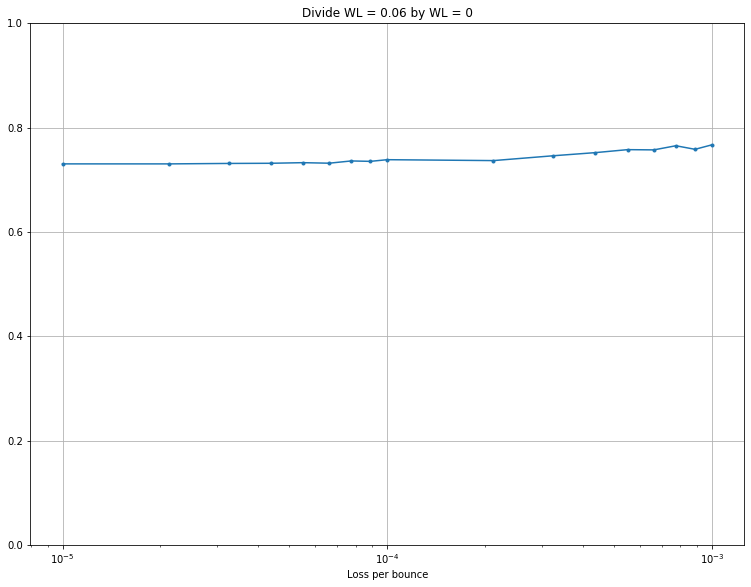

In [40]:
from scipy.interpolate import interp1d

dfQ = df.query('windowLoss == 0').sort_values(by='lossPerBounce')
wL_curve1 = interp1d(dfQ['lossPerBounce'].to_list(), dfQ['neutronsInCell'].to_list(), kind='cubic')

dfQ = df.query('windowLoss == 0.06').sort_values(by='lossPerBounce')
wL_curve2 = interp1d(dfQ['lossPerBounce'].to_list(), dfQ['neutronsInCell'].to_list(), kind='cubic')


dfQ = df.query('windowLoss == 0.06 and 1E-5<=lossPerBounce<=1E-3').sort_values(by='lossPerBounce')
x = dfQ['lossPerBounce'].to_list()

plt.figure(figsize=(6.4*2, 4.8*2))
plt.ylim([0,1])
plt.xscale('log')
plt.title('Divide WL = 0.06 by WL = 0')
plt.xlabel('Loss per bounce')
plt.grid()
plt.plot( x, np.divide(dfQ['neutronsInCell'].to_list(), wL_curve1(x) ), label='wL = 0.06 normalized', marker='.' )

print('Average Loss: ', 1 -np.mean(np.divide(dfQ['neutronsInCell'].to_list(), wL_curve1(x) )))

